In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import json
from datetime import datetime

In [3]:
df = pd.read_csv("email_evaluations.csv")

In [5]:
df.head(2)

,id,model,prompt,task,response,evaluation,comment,candidate_name,position,role_level,timestamp
0,dc384399-cb1c-452c-81b6-ef211e112664,openai-gpt,\n\n Extract the information from the PDF f...,Email,Subject: Exciting Opportunity for a Data Scien...,Bad,Didn't identify the role and the position was ...,Pastor Soto,Data Scientist,Mid,2025-04-19T20:34:11.730322
1,c62f7714-6c33-4e17-8d5a-00e55d6ffe5e,openai-gpt,\n\n Extract the information from the PDF f...,Email,Subject: Exciting Opportunity for a Skilled AI...,Bad,"Didn't propose a role but at the end, even tho...",Andrew Ng,MLE,Senior,2025-04-19T20:35:27.410901


/tmp/ipykernel_159809/4026797221.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Evaluation')


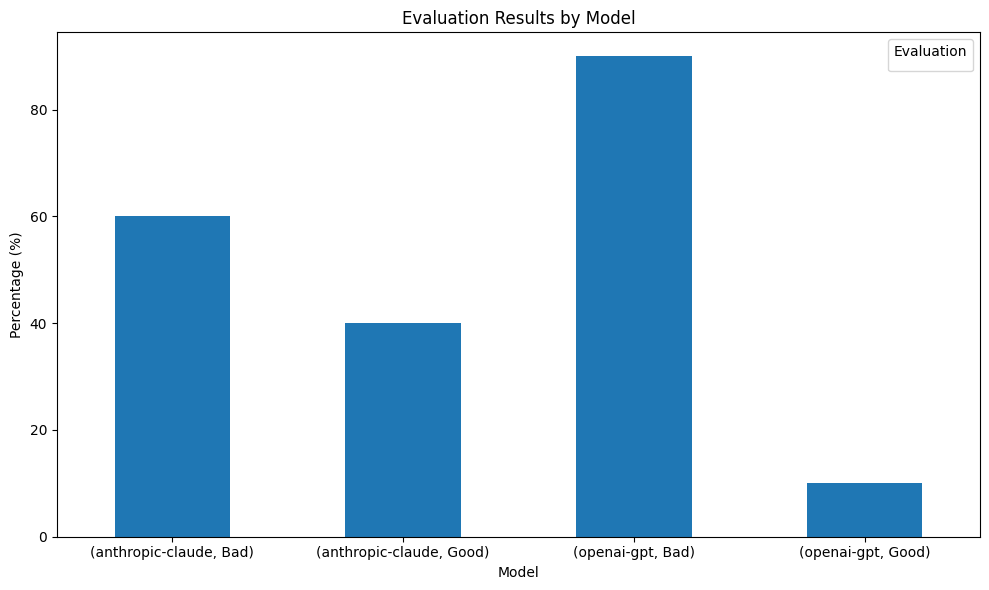

In [7]:
import matplotlib.pyplot as plt
# Group by model and evaluation, then count occurrences and express as percentage
evaluation_summary = df.groupby(['model', 'evaluation']).size().unstack(fill_value=0)
evaluation_summary = evaluation_summary.div(evaluation_summary.sum(axis=1), axis=0) * 100
# Reset the index to make 'model' a column
evaluation_summary.reset_index(inplace=True)
# Set the model as the index for better plotting
evaluation_summary.set_index('model', inplace=True)
# Transpose the DataFrame for better plotting
evaluation_summary = evaluation_summary.transpose()
# Set the color palette
colors = ['#FF9999', '#66B3FF', '#99FF99']
# Create the bar plot
plt.figure(figsize=(10, 6))
evaluation_summary.unstack().plot(kind='bar')
plt.title('Evaluation Results by Model')
plt.xlabel('Model')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Evaluation')
plt.tight_layout()
plt.show()

In [14]:
from openai import OpenAI
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))

def evaluate_with_llm(row):
    """Use LLM to evaluate email response quality"""
    
    prompt = f"""You are an expert evaluator of email communications. Evaluate the following email response that was generated for a candidate based on their profile.

Context:
- Candidate Name: {row['candidate_name']}
- Position: {row['position']}
- Role Level: {row['role_level']}

Email Response:
{row['response']}

Evaluate the email on:
1. Appropriate tone and professionalism
2. Relevance to candidate's background
3. Clear communication of role/opportunity
4. Personalization

Provide your evaluation as either "Good" or "Bad" followed by a brief reason.
Only respond with this format:
EVALUATION: [Good/Bad]
REASON: [1-2 sentence explanation]
"""

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert email evaluator. Be concise and direct in your evaluation."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )
    
    eval_text = response.choices[0].message.content
    
    # Parse the evaluation and reason
    eval_lines = eval_text.split('\n')
    evaluation = eval_lines[0].replace('EVALUATION:', '').strip()
    reason = eval_lines[1].replace('REASON:', '').strip()
    
    return evaluation, reason

# Add LLM evaluation columns
df['llm_evaluation'] = None
df['llm_reason'] = None

# Process each row
for idx, row in df.iterrows():
    try:
        evaluation, reason = evaluate_with_llm(row)
        df.at[idx, 'llm_evaluation'] = evaluation
        df.at[idx, 'llm_reason'] = reason
        print(f"Processed row {idx}")
    except Exception as e:
        print(f"Error processing row {idx}: {str(e)}")
        
# Calculate agreement rate between human and LLM evaluations
agreement_rate = (df['evaluation'] == df['llm_evaluation']).mean()
print(f"\nAgreement rate between human and LLM evaluations: {agreement_rate:.2%}")

# Display comparison of evaluations
comparison_df = df[['candidate_name', 'position', 'evaluation', 'llm_evaluation', 'comment', 'llm_reason']]
display(comparison_df)


Processed row 0
Processed row 1
Processed row 2
Processed row 3
Processed row 4
Processed row 5
Processed row 6
Processed row 7
Processed row 8
Processed row 9
Processed row 10
Processed row 11
Processed row 12
Processed row 13
Processed row 14
Processed row 15
Processed row 16
Processed row 17
Processed row 18
Processed row 19

Agreement rate between human and LLM evaluations: 25.00%


,candidate_name,position,evaluation,llm_evaluation,comment,llm_reason
0,Pastor Soto,Data Scientist,Bad,Good,Didn't identify the role and the position was ...,The email is professional and maintains an app...
1,Andrew Ng,MLE,Bad,Good,"Didn't propose a role but at the end, even tho...",The email is professional and respectful in to...
2,Greg Gandenberger,MLE,Bad,Good,Didn't identify correctly the name and the pos...,The email maintains a professional tone and cl...
3,Greg Ganderberger,MLE,Good,Good,"This was accurate in the name, position and role",The email is professional and maintains an app...
4,Susan Shu Change,Data Scientist,Good,Good,Identifies the role name and position accurate,The email is professional and respectful in to...
5,Susan Shu Change,Data Scientist,Bad,Good,It identifies everything but the response wasn...,"The email is professional and personalized, hi..."
6,Susan Shu Chang,Data Scientist,Good,Good,"Identifies the name, the offer was in front an...",The email is professional and maintains an app...
7,Susan Shu Change,Data Scientist,Bad,Good,"The position was at the end, it identifies the...",The email is professional and maintains an app...
8,Pastor Soto,Data Scientist,Bad,Good,not at the level of senior,The email maintains a professional tone throug...
9,Pastor Soto,Data Scientist,Bad,Good,Not at a level of a senior,"The email is professional, personalized, and c..."


Classification Metrics (Human vs LLM):
Accuracy: 0.25
Precision: 0.25
Recall: 1.00
F1 Score: 0.40


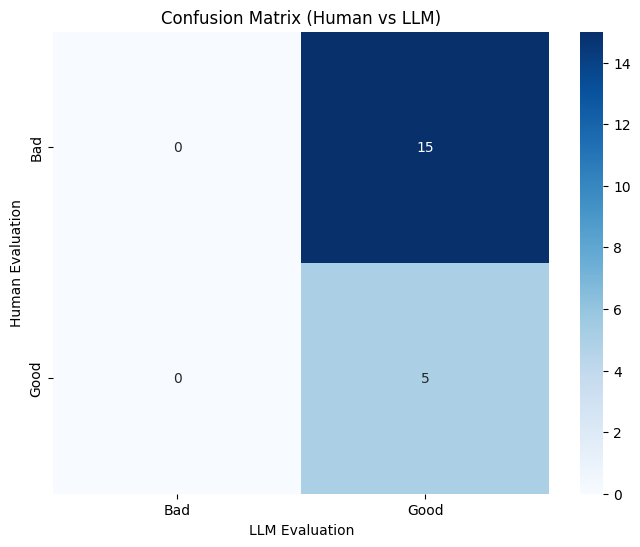


Metrics by Model (Human vs LLM):

openai-gpt:
Accuracy: 0.10
Precision: 0.10
Recall: 1.00
F1 Score: 0.18

anthropic-claude:
Accuracy: 0.40
Precision: 0.40
Recall: 1.00
F1 Score: 0.57


In [16]:
# Convert evaluations to binary (Good=1, Bad=0) for both human and LLM evaluations
y_true = (df['evaluation'] == 'Good').astype(int)
y_pred = (df['llm_evaluation'] == 'Good').astype(int)

# Calculate metrics comparing human evaluation vs LLM evaluation
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
conf_matrix = confusion_matrix(y_true, y_pred)

# Print metrics
print("Classification Metrics (Human vs LLM):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad', 'Good'],
            yticklabels=['Bad', 'Good'])
plt.title('Confusion Matrix (Human vs LLM)')
plt.xlabel('LLM Evaluation')
plt.ylabel('Human Evaluation')
plt.show()

# Calculate metrics per model
print("\nMetrics by Model (Human vs LLM):")
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    y_true_model = (model_data['evaluation'] == 'Good').astype(int)
    y_pred_model = (model_data['llm_evaluation'] == 'Good').astype(int)
    
    accuracy = accuracy_score(y_true_model, y_pred_model)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_model, y_pred_model, average='binary')
    
    print(f"\n{model}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")



In this case the Judge only evaluates the email but not how accurate was identifying the details, which was the most common failure mode.

As follow-up, we can pass the correct info to the judge to see how it behaves.